In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
import torchvision
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import helper

### Dataloader

In [2]:
class MyDataset(Dataset):
    def __init__(self, images_folder, masks_folder,
                 img_transform=None, masks_transform=None):
        super(Dataset, self).__init__()
        
        self.images_folder = images_folder
        self.masks_folder = masks_folder

        self.images_names = np.sort(os.listdir(images_folder))
        self.masks_names = np.sort(os.listdir(masks_folder))
        
        self.img_transform = img_transform
        self.masks_transform = masks_transform

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        item_image = np.load(os.path.join(self.images_folder,
                                            self.images_names[idx]))
        item_mask = np.load(os.path.join(self.masks_folder,
                                              self.masks_names[idx]))
        
        SEED = np.random.randint(123456789)
        if self.img_transform is not None:
            random.seed(SEED)
            item_image = self.img_transform(item_image)
        if self.masks_transform is not None:  
            random.seed(SEED)
            item_mask = self.masks_transform(item_mask)

        return item_image, item_mask

In [3]:
trans = transforms.Compose([
    transforms.ToTensor(),
])
train_set = MyDataset(images_folder = './train_val_dataset/train/images', 
                      masks_folder = './train_val_dataset/train/masks',
                      img_transform = trans, masks_transform = trans)
val_set = MyDataset(images_folder = './train_val_dataset/val/images', 
                      masks_folder = './train_val_dataset/val/masks',
                      img_transform = trans, masks_transform = trans)

In [4]:
image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size_train = 2
batch_size_val = 2

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 60, 'val': 27}

In [5]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print('Image shape:', inputs.shape)
print('Mask shape:', masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

Image shape: torch.Size([2, 3, 400, 400])
Mask shape: torch.Size([2, 3, 400, 400])
0.0 1.0 0.935825 0.24506447
0.0 1.0 0.020975 0.14330053


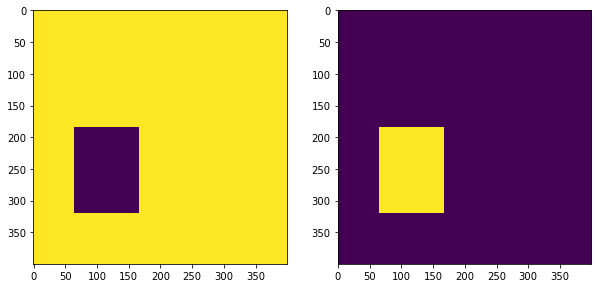

In [6]:
fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(10, 10))
axs[0].imshow(inputs[0][0], interpolation='none')
axs[1].imshow(masks[0][0], interpolation='none')
plt.show()

In [7]:
from torchsummary import summary
import torch
import torch.nn as nn
import unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = unet.UNet(3)
# model = model.to(device)

# summary(model, input_size=(3, 400, 400))

In [8]:
logs_base_dir = './logs'
os.makedirs(logs_base_dir, exist_ok=True)

In [9]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, experiment_name, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    writer = SummaryWriter(f'{logs_base_dir}/{experiment_name}')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)    

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples   
            writer.add_scalar(f'Loss_{phase}', epoch_loss.item(), global_step=epoch)
            
            dsc_epoch = metrics['dice'] / epoch_samples
            writer.add_scalar(f'DICE_{phase}', (1.-dsc_epoch.item()), global_step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import unet_9x9
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = unet_9x9.UNet(num_class).to(device)

optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

cuda:0


In [12]:
Model = 'Unet_9x9'

# Options:
#     - with_kernel
#     - usual
model_type = 'with_kernel_255'

exp_name = datetime.now().isoformat(timespec='minutes') + '_' + Model + '_' + model_type   

### Create kernel

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from pyefd import elliptic_fourier_descriptors
from pyEFD import plot_efd

import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
jpg_masks_folder = '/home/e_radionova/cig5_Research_optimal_kernels/Dataset_parametrezation/dataset_creation_simple_shapes/dataset_jpg'
jpg_masks_names = np.sort(os.listdir(jpg_masks_folder))

In [15]:
# Find contours for circle

path = jpg_masks_folder + '/'
contours_dict_jpg = dict.fromkeys(jpg_masks_names)

for mask in contours_dict_jpg.keys():
    img = cv2.imread(path + mask)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_new = np.vstack(contours).squeeze()
    order = 10
    coeffs = elliptic_fourier_descriptors(contours_new, order=order)
    contours_dict_jpg[mask] = coeffs

In [16]:
sum_contours = 0
sum_index = 0
for i, cont in enumerate(list(contours_dict_jpg.values())):
    sum_contours += cont
    sum_index += i
    
coeffs_mean = sum_contours / sum_index

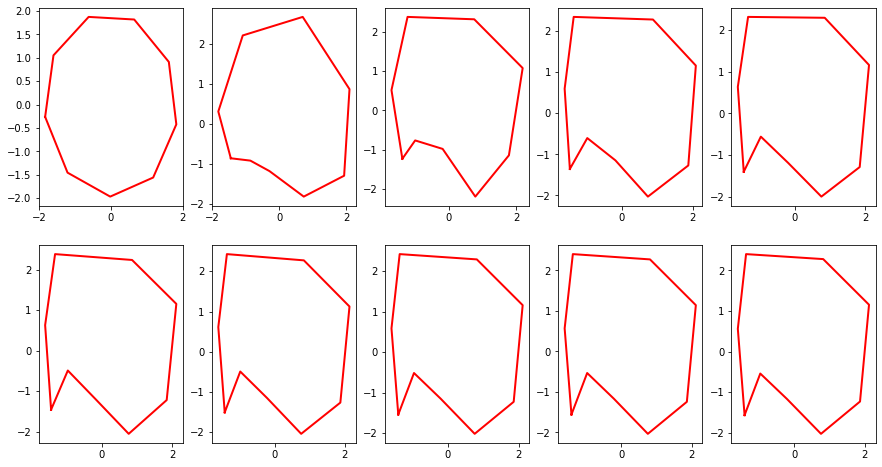

In [17]:
plot_efd(coeffs_mean, n=10)

In [18]:
locus = (0.0, 0.0)
m=10
xt = np.ones((m,)) * locus[0]
yt = np.ones((m,)) * locus[1]

t = np.linspace(0, 1.0, m)
    
for n in range(coeffs_mean.shape[0]):
    xt += (coeffs_mean[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
        coeffs_mean[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
    )
    yt += (coeffs_mean[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
        coeffs_mean[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
    )

(-1.7883123175185462,
 2.3031615741668983,
 -2.2499774999192983,
 2.625173975485726)

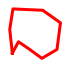

In [19]:
fig = plt.figure(figsize=(1, 1))
ax = fig.add_subplot(111)
ax.plot(xt, yt, 'r', linewidth=3)
ax.axis('off')

### Transform from plot to numpy

In [20]:
def get_img_from_fig(fig, dpi):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [21]:
plot_img_np = get_img_from_fig(fig, dpi=9)

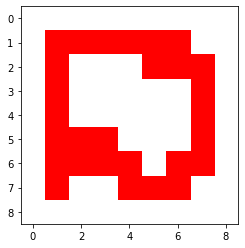

In [22]:
plt.imshow(plot_img_np)

In [23]:
plot_img_np = plot_img_np.transpose(2,0,1)

In [24]:
plot_img_np = plot_img_np / 255

In [25]:
# plot_img_np = (~plot_img_np.astype(bool)).astype(int)

In [26]:
with open('kernel.npy', 'wb') as f:
    np.save(f, plot_img_np)

### Kernel initialization

In [27]:
shape_k = model._modules['dconv_down1'][0].weight.data.shape
kernel = torch.zeros_like(torch.rand(shape_k))

In [28]:
kernel_load = np.load('kernel.npy')
kernel_new = torch.from_numpy(kernel_load)

In [29]:
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        kernel[i][j] = kernel_new[1]

In [30]:
model._modules['dconv_down1'][0].weight.data = kernel
model._modules['dconv_down1'][0].weight.data = model._modules['dconv_down1'][0].weight.data.to(device)

In [31]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, experiment_name=exp_name, num_epochs=20) 

Epoch 0/19
----------
LR 0.001
train: bce: 1.497508, dice: 0.826293, loss: 1.161901
val: bce: 0.349427, dice: 0.809533, loss: 0.579480
saving best model
0m 4s
Epoch 1/19
----------
LR 0.001
train: bce: 2.644837, dice: 0.763875, loss: 1.704356
val: bce: 2.246944, dice: 0.791812, loss: 1.519378
0m 4s
Epoch 2/19
----------
LR 0.001
train: bce: 5.751086, dice: 0.737756, loss: 3.244421
val: bce: 2.438160, dice: 0.837820, loss: 1.637990
0m 4s
Epoch 3/19
----------
LR 0.001
train: bce: 5.841405, dice: 0.591302, loss: 3.216353
val: bce: 0.066085, dice: 0.008022, loss: 0.037054
saving best model
0m 4s
Epoch 4/19
----------
LR 0.001
train: bce: 0.060132, dice: 0.009656, loss: 0.034894
val: bce: 0.005344, dice: 0.003669, loss: 0.004506
saving best model
0m 4s
Epoch 5/19
----------
LR 0.001
train: bce: 0.002187, dice: 0.001792, loss: 0.001990
val: bce: 0.001061, dice: 0.001493, loss: 0.001277
saving best model
0m 4s
Epoch 6/19
----------
LR 0.001
train: bce: 0.001023, dice: 0.000946, loss: 0.00098